In [1]:
# 🚀 LSTM Time Embedding Comparison - Complete Setup Cell
print("🔧 Setting up LSTM Time Embedding Comparison...")

# Core imports
import os
import sys
import time
import json
import csv
import warnings
warnings.filterwarnings('ignore')

# Deep learning imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Data processing
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms
from tqdm.auto import tqdm # Import tqdm

# Add project root to path
project_root = '/home/peera/kan-mammote'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import project modules
from src.models.kan_mammote import KANMAMMOTE
from src.utils.config import KANMAMMOTEConfig
from src.LETE.LeTE import CombinedLeTE as LeTE # Import CombinedLeTE and alias it as LeTE

# Configuration
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 1
LSTM_HIDDEN_DIM = 128
TIME_EMBEDDING_DIM = 64
DROPOUT_RATE = 0.2
THRESHOLD = 0.3
GRAD_CLIP_NORM = 1.0

# Setup device and directories
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")

RESULTS_DIR = f"{project_root}/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

class EventBasedMNIST(Dataset):
    """Convert MNIST to event-based representation."""
    
    def __init__(self, root, train=True, threshold=0.3, download=False):
        self.threshold = threshold
        transform = transforms.Compose([transforms.ToTensor()])
        self.mnist = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        
    def __len__(self):
        return len(self.mnist)
        
    def __getitem__(self, idx):
        image, label = self.mnist[idx]
        
        # Convert to event representation
        image = image.squeeze().numpy()
        
        # Create events for pixels above threshold
        events = []
        features = []
        
        for i in range(28):
            for j in range(28):
                if image[i, j] > self.threshold:
                    position = i * 28 + j  # Flatten position
                    events.append(position)
                    features.append(image[i, j])
        
        if len(events) == 0:
            events = [0]
            features = [0.0]
        
        return np.array(events), np.array(features), label

def collate_fn(batch):
    """Custom collate function for variable length sequences."""
    events_batch = []
    features_batch = []
    lengths = []
    labels = []
    
    max_len = max(len(events) for events, _, _ in batch)
    
    for events, features, label in batch:
        length = len(events)
        lengths.append(length)
        labels.append(label)
        
        # Pad sequences
        padded_events = np.zeros(max_len, dtype=np.int64)
        padded_features = np.zeros(max_len, dtype=np.float32)
        
        padded_events[:length] = events
        padded_features[:length] = features
        
        events_batch.append(padded_events)
        features_batch.append(padded_features)
    
    return (torch.tensor(events_batch), 
            torch.tensor(features_batch), 
            torch.tensor(lengths), 
            torch.tensor(labels))

def count_parameters(model):
    """Count trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TrueBaselineLSTM(nn.Module):
    """True baseline LSTM without any time embeddings."""
    
    def __init__(self, input_size=784, hidden_dim=128, num_classes=10, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Just use feature values directly
        self.lstm = nn.LSTM(
            input_size=1,  # Just the pixel values
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, events, features, lengths):
        if features.size(0) == 0:
            return torch.zeros(0, 10, device=features.device)
        
        lengths = torch.clamp(lengths, min=1, max=features.size(1))
        
        # Use only pixel values, no positional information
        x = features.unsqueeze(-1)  # Add feature dimension
        
        # Pack sequences
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, c_n) = self.lstm(packed)
        
        # Classify using last hidden state
        output = self.classifier(h_n[-1])
        return output

class LearnablePositionLSTM(nn.Module):
    """LSTM with learnable position embeddings."""
    
    def __init__(self, input_size=784, hidden_dim=128, num_classes=10, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        
        # Learnable position embedding
        self.position_embedding = nn.Embedding(input_size, TIME_EMBEDDING_DIM)
        
        # Feature projection
        self.feature_proj = nn.Linear(1, TIME_EMBEDDING_DIM)
        
        self.lstm = nn.LSTM(
            input_size=TIME_EMBEDDING_DIM,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, events, features, lengths):
        if events.size(0) == 0:
            return torch.zeros(0, 10, device=events.device)
        
        lengths = torch.clamp(lengths, min=1, max=events.size(1))
        
        # Get position embeddings
        pos_emb = self.position_embedding(events)
        
        # Project features
        feat_emb = self.feature_proj(features.unsqueeze(-1))
        
        # Combine position and feature embeddings
        combined = pos_emb + feat_emb
        
        # Pack sequences
        packed = pack_padded_sequence(combined, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, c_n) = self.lstm(packed)
        
        # Classify
        output = self.classifier(h_n[-1])
        return output

class SinCosLSTM(nn.Module):
    """LSTM with sinusoidal position embeddings."""
    
    def __init__(self, input_size=784, hidden_dim=128, num_classes=10, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Feature projection
        self.feature_proj = nn.Linear(1, TIME_EMBEDDING_DIM)
        
        self.lstm = nn.LSTM(
            input_size=TIME_EMBEDDING_DIM,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def get_sincos_embeddings(self, positions):
        """Generate sinusoidal position embeddings."""
        batch_size, seq_len = positions.shape
        embeddings = torch.zeros(batch_size, seq_len, TIME_EMBEDDING_DIM, device=positions.device)
        
        # Normalize positions to [0, 1]
        max_pos = positions.max(dim=1, keepdim=True)[0].float()
        normalized_pos = positions.float() / (max_pos + 1e-8)
        
        div_term = torch.exp(torch.arange(0, TIME_EMBEDDING_DIM, 2, device=positions.device).float() * 
                            -(np.log(10000.0) / TIME_EMBEDDING_DIM))
        
        pos_scaled = normalized_pos.unsqueeze(-1) * div_term.unsqueeze(0).unsqueeze(0)
        
        embeddings[:, :, 0::2] = torch.sin(pos_scaled)
        embeddings[:, :, 1::2] = torch.cos(pos_scaled)
        
        return embeddings
        
    def forward(self, events, features, lengths):
        if events.size(0) == 0:
            return torch.zeros(0, 10, device=events.device)
        
        lengths = torch.clamp(lengths, min=1, max=events.size(1))
        
        # Get sinusoidal position embeddings
        pos_emb = self.get_sincos_embeddings(events)
        
        # Project features
        feat_emb = self.feature_proj(features.unsqueeze(-1))
        
        # Combine embeddings
        combined = pos_emb + feat_emb
        
        # Pack sequences
        packed = pack_padded_sequence(combined, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, c_n) = self.lstm(packed)
        
        # Classify
        output = self.classifier(h_n[-1])
        return output

class LETE_LSTM_Fixed(nn.Module):
    """LSTM with LETE time embeddings - FIXED."""
    
    def __init__(self, input_size=784, hidden_dim=128, num_classes=10, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes # Ensure this line is present (fixed in last response)
        
        # Initialize LETE
        self.lete = LeTE(dim=TIME_EMBEDDING_DIM)
        
        # Feature projection
        self.feature_proj = nn.Linear(1, TIME_EMBEDDING_DIM)
        
        self.lstm = nn.LSTM(
            input_size=TIME_EMBEDDING_DIM,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, events, features, lengths):
        # Input validation
        if events.size(0) == 0:
            return torch.zeros(0, self.num_classes, device=events.device)
        
        # Clamp lengths to prevent issues
        lengths = torch.clamp(lengths, min=1, max=events.size(1))
        
        # Process valid sequences only
        valid_mask = lengths > 0
        if not valid_mask.any():
            return torch.zeros(events.size(0), self.num_classes, device=events.device)
        
        events_valid = events[valid_mask]
        features_valid = features[valid_mask]
        lengths_valid = lengths[valid_mask]

        # Normalize timestamps (result shape: [valid_batch_size, seq_len])
        max_pos = events_valid.max(dim=1, keepdim=True)[0].float()
        max_pos[max_pos == 0] = 1.0 # Prevent division by zero for empty sequences
        timestamps_norm = events_valid.float() / (max_pos + 1e-8) # Added small epsilon for numerical stability
        
        # DEBUG CHECK 1: Check timestamps_norm
        if torch.isnan(timestamps_norm).any() or torch.isinf(timestamps_norm).any():
            raise ValueError(f"NaN/Inf detected in timestamps_norm. Range: [{timestamps_norm.min().item():.4f}, {timestamps_norm.max().item():.4f}]")

        # Get LETE embeddings
        lete_emb = self.lete(timestamps_norm) 
        
        # DEBUG CHECK 2: lete_emb (output of CombinedLeTE) - Most likely place for NaNs
        if torch.isnan(lete_emb).any() or torch.isinf(lete_emb).any():
            raise ValueError(f"NaN/Inf detected in lete_emb (output of CombinedLeTE). Range: [{lete_emb.min().item():.4f}, {lete_emb.max().item():.4f}]")
        
        # Ensure shape matches, if not, something is fundamentally wrong in CombinedLeTE
        batch_size_valid, seq_len_valid = timestamps_norm.shape
        if lete_emb.shape != (batch_size_valid, seq_len_valid, TIME_EMBEDDING_DIM):
            raise ValueError(f"CombinedLeTE output shape mismatch: Expected "
                             f"({batch_size_valid}, {seq_len_valid}, {TIME_EMBEDDING_DIM}), "
                             f"got {lete_emb.shape}")

        # Clip to prevent numerical issues (good practice, can prevent exploding values from propagating)
        lete_emb = torch.clamp(lete_emb, min=-1e5, max=1e5) # Increased range for a bit more robustness
        
        # Project features
        feat_emb = self.feature_proj(features_valid.unsqueeze(-1))

        # DEBUG CHECK 3: feat_emb
        if torch.isnan(feat_emb).any() or torch.isinf(feat_emb).any():
            raise ValueError(f"NaN/Inf detected in feat_emb. Range: [{feat_emb.min().item():.4f}, {feat_emb.max().item():.4f}]")
        
        # Combine embeddings
        combined_valid = lete_emb + feat_emb
        
        # DEBUG CHECK 4: combined_valid after addition
        if torch.isnan(combined_valid).any() or torch.isinf(combined_valid).any():
            raise ValueError(f"NaN/Inf detected in combined_valid after addition. Range: [{combined_valid.min().item():.4f}, {combined_valid.max().item():.4f}]")
            
        combined_valid = F.relu(combined_valid) # ReLU is generally safe but can pass Inf
        
        # DEBUG CHECK 5: combined_valid after ReLU
        if torch.isnan(combined_valid).any() or torch.isinf(combined_valid).any():
            raise ValueError(f"NaN/Inf detected in combined_valid after ReLU. Range: [{combined_valid.min().item():.4f}, {combined_valid.max().item():.4f}]")
        
        # Apply sequence mask
        seq_mask = torch.arange(combined_valid.size(1), device=lengths_valid.device)[None, :] < lengths_valid[:, None]
        combined_valid = combined_valid * seq_mask.unsqueeze(-1).float()
        
        # DEBUG CHECK 6: combined_valid after masking
        if torch.isnan(combined_valid).any() or torch.isinf(combined_valid).any():
            raise ValueError(f"NaN/Inf detected in combined_valid after masking. Range: [{combined_valid.min().item():.4f}, {combined_valid.max().item():.4f}]")
        
        # LSTM processing
        packed = pack_padded_sequence(combined_valid, lengths_valid.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, c_n) = self.lstm(packed) # LSTM can propagate NaNs if inputs are extreme
        
        # DEBUG CHECK 7: h_n (LSTM hidden state)
        if torch.isnan(h_n).any() or torch.isinf(h_n).any():
            raise ValueError(f"NaN/Inf detected in h_n (LSTM hidden state). Range: [{h_n.min().item():.4f}, {h_n.max().item():.4f}]")
        
        # Classifier
        valid_logits = self.classifier(h_n[-1])
        
        # DEBUG CHECK 8: valid_logits (classifier output)
        if torch.isnan(valid_logits).any() or torch.isinf(valid_logits).any():
            raise ValueError(f"NaN/Inf detected in valid_logits (classifier output). Range: [{valid_logits.min().item():.4f}, {valid_logits.max().item():.4f}]")
        
        # Create full output tensor and place valid logits back
        full_logits = torch.zeros(events.size(0), self.num_classes, device=events.device)
        full_logits[valid_mask] = valid_logits
        
        return full_logits
class KAN_MAMMOTE_LSTM_Fixed(nn.Module):
    def __init__(self, input_size=784, hidden_dim=128, num_classes=10, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes # ADDED: Ensure num_classes is stored as an attribute
        
        kan_mammote_internal_feature_dim = 16 
        self.kan_mammote_input_feature_proj = nn.Linear(1, kan_mammote_internal_feature_dim)
        
        self.kan_config = KANMAMMOTEConfig(
            d_model=TIME_EMBEDDING_DIM,
            D_time=TIME_EMBEDDING_DIM, 
            input_feature_dim=kan_mammote_internal_feature_dim,
            output_dim_for_task=TIME_EMBEDDING_DIM,
            K_top=4,
            use_aux_features_router=False,
            raw_event_feature_dim=0,
            num_layers=1,
            lambda_sobolev_l2=0.0,
            lambda_total_variation=0.0,
        )
        
        self.kan_mammote = KANMAMMOTE(self.kan_config)
        
        self.feature_proj = nn.Linear(1, TIME_EMBEDDING_DIM)
        
        self.combine = nn.Linear(TIME_EMBEDDING_DIM * 2, TIME_EMBEDDING_DIM)
        
        self.lstm = nn.LSTM(
            input_size=TIME_EMBEDDING_DIM, 
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, events, features, lengths):
        # Initial validation and masking (unchanged, good for handling empty batches)
        if events.size(0) == 0:
            return torch.zeros(0, self.num_classes, device=events.device)
        
        lengths = torch.clamp(lengths, min=1, max=events.size(1))
        
        valid_mask = lengths > 0
        if not valid_mask.any():
            return torch.zeros(events.size(0), self.num_classes, device=events.device)
        
        events_valid = events[valid_mask]
        features_valid = features[valid_mask]
        lengths_valid = lengths[valid_mask]
        
        # Normalize timestamps
        max_pos = events_valid.max(dim=1, keepdim=True)[0].float()
        max_pos[max_pos == 0] = 1.0 # Avoid division by zero for empty sequences
        timestamps_norm = events_valid.float() / (max_pos + 1e-8) # Added epsilon for safety
        
        # DEBUG CHECK: Check timestamps_norm
        if torch.isnan(timestamps_norm).any() or torch.isinf(timestamps_norm).any():
            raise ValueError(f"NaN/Inf detected in timestamps_norm. Range: [{timestamps_norm.min().item():.4f}, {timestamps_norm.max().item():.4f}]")

        # Project input features for KAN-MAMMOTE
        kan_mammote_input_features = self.kan_mammote_input_feature_proj(features_valid.unsqueeze(-1))
        
        # DEBUG CHECK: Check kan_mammote_input_features
        if torch.isnan(kan_mammote_input_features).any() or torch.isinf(kan_mammote_input_features).any():
            raise ValueError(f"NaN/Inf detected in kan_mammote_input_features. Range: [{kan_mammote_input_features.min().item():.4f}, {kan_mammote_input_features.max().item():.4f}]")

        # Process through KAN-MAMMOTE
        kan_embeddings, kan_mammote_losses = self.kan_mammote(
            timestamps=timestamps_norm,
            features=kan_mammote_input_features,
            auxiliary_features=None
        )
        
        # DEBUG CHECK: kan_embeddings (This is a very common place for NaNs to appear in custom complex models)
        if torch.isnan(kan_embeddings).any() or torch.isinf(kan_embeddings).any():
            raise ValueError(f"NaN/Inf detected in kan_embeddings (output of KANMAMMOTE). Range: [{kan_embeddings.min().item():.4f}, {kan_embeddings.max().item():.4f}]")
        
        # Project original pixel features for the parallel path
        feat_emb = self.feature_proj(features_valid.unsqueeze(-1))
        
        # DEBUG CHECK: feat_emb
        if torch.isnan(feat_emb).any() or torch.isinf(feat_emb).any():
            raise ValueError(f"NaN/Inf detected in feat_emb. Range: [{feat_emb.min().item():.4f}, {feat_emb.max().item():.4f}]")
        
        # Combine embeddings from both pathways
        combined_valid = torch.cat([kan_embeddings, feat_emb], dim=-1)
        
        # DEBUG CHECK: combined_valid after concat
        if torch.isnan(combined_valid).any() or torch.isinf(combined_valid).any():
            raise ValueError(f"NaN/Inf detected in combined_valid after concat. Range: [{combined_valid.min().item():.4f}, {combined_valid.max().item():.4f}]")

        combined_valid = self.combine(combined_valid)
        
        # DEBUG CHECK: combined_valid after self.combine
        if torch.isnan(combined_valid).any() or torch.isinf(combined_valid).any():
            raise ValueError(f"NaN/Inf detected in combined_valid after self.combine. Range: [{combined_valid.min().item():.4f}, {combined_valid.max().item():.4f}]")
            
        combined_valid = F.relu(combined_valid) # ReLU is generally safe, but can propagate Inf
        
        # DEBUG CHECK: combined_valid after ReLU
        if torch.isnan(combined_valid).any() or torch.isinf(combined_valid).any():
            raise ValueError(f"NaN/Inf detected in combined_valid after ReLU. Range: [{combined_valid.min().item():.4f}, {combined_valid.max().item():.4f}]")
        
        # Apply sequence mask
        batch_size_valid, max_seq_len_valid = combined_valid.shape[0], combined_valid.shape[1]
        seq_mask = torch.arange(max_seq_len_valid, device=lengths_valid.device)[None, :] < lengths_valid[:, None]
        combined_valid = combined_valid * seq_mask.unsqueeze(-1).float()
        
        # DEBUG CHECK: combined_valid after masking
        if torch.isnan(combined_valid).any() or torch.isinf(combined_valid).any():
            raise ValueError(f"NaN/Inf detected in combined_valid after masking. Range: [{combined_valid.min().item():.4f}, {combined_valid.max().item():.4f}]")
        
        # LSTM processing
        packed = pack_padded_sequence(combined_valid, lengths_valid.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, c_n) = self.lstm(packed) # LSTM can propagate NaNs if inputs are extreme
        
        # DEBUG CHECK: h_n (LSTM hidden state)
        if torch.isnan(h_n).any() or torch.isinf(h_n).any():
            raise ValueError(f"NaN/Inf detected in h_n (LSTM hidden state). Range: [{h_n.min().item():.4f}, {h_n.max().item():.4f}]")
        
        # Classifier
        valid_logits = self.classifier(h_n[-1])
        
        # DEBUG CHECK: valid_logits (classifier output)
        if torch.isnan(valid_logits).any() or torch.isinf(valid_logits).any():
            raise ValueError(f"NaN/Inf detected in valid_logits (classifier output). Range: [{valid_logits.min().item():.4f}, {valid_logits.max().item():.4f}]")
        
        # Create full output tensor and place valid logits back
        full_logits = torch.zeros(events.size(0), self.num_classes, device=events.device)
        full_logits[valid_mask] = valid_logits
        
        return full_logits
        
def train_model(model, train_loader, test_loader, model_name):
    """Train a single model with immediate error stopping."""
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    history = {
        'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [],
        'epochs': [], 'training_time': []
    }
    
    best_test_acc = 0.0
    
    print(f"Training {model_name}...")
    
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (events, features, lengths, labels) in enumerate(train_pbar):
            # No try-except here - let errors propagate and stop execution
            events, features, lengths, labels = events.to(device), features.to(device), lengths.to(device), labels.to(device)
            
            # Debug info for first few batches
            '''if batch_idx < 3:
                print(f"\n📊 Batch {batch_idx} debug:")
                print(f"  - events: shape={events.shape}, range=[{events.min().item()}, {events.max().item()}]")
                print(f"  - features: shape={features.shape}, range=[{features.min().item()}, {features.max().item()}]")
                print(f"  - lengths: shape={lengths.shape}, range=[{lengths.min().item()}, {lengths.max().item()}]")
                print(f"  - labels: shape={labels.shape}, values={labels.tolist()}")'''
            
            optimizer.zero_grad()
            
            outputs = model(events, features, lengths)
            
            # Check outputs and raise error if issues are found
            if torch.isnan(outputs).any():
                print(f"⚠️ NaN detected in outputs at batch {batch_idx}!")
                raise ValueError(f"NaN detected in model outputs at batch {batch_idx}")
                
            loss = criterion(outputs, labels)
            
            # Check loss and raise error if issues are found
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠️ NaN/Inf loss detected at batch {batch_idx}: {loss.item()}")
                raise ValueError(f"NaN or Inf loss value detected at batch {batch_idx}: {loss.item()}")
            
            loss.backward()
            
            # Check gradients and raise error if issues are found
            for name, param in model.named_parameters():
                if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
                    print(f"⚠️ NaN/Inf gradient detected in {name}")
                    raise ValueError(f"NaN or Inf gradient detected in parameter {name}")
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Update tqdm postfix
            train_pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*train_correct/train_total:.2f}%")
        
        train_pbar.close()

        # Validation phase
        model.eval()
        test_pbar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Test]", leave=False)
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch_idx, (events, features, lengths, labels) in enumerate(test_pbar):
                # No try-except here - let errors propagate and stop execution
                events, features, lengths, labels = events.to(device), features.to(device), lengths.to(device), labels.to(device)
                
                outputs = model(events, features, lengths)
                
                # Check outputs and raise error if issues are found
                if torch.isnan(outputs).any():
                    print(f"⚠️ NaN detected in test outputs at batch {batch_idx}!")
                    raise ValueError(f"NaN detected in test model outputs at batch {batch_idx}")
                    
                loss = criterion(outputs, labels)
                
                # Check loss and raise error if issues are found
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"⚠️ NaN/Inf test loss detected at batch {batch_idx}: {loss.item()}")
                    raise ValueError(f"NaN or Inf test loss value detected at batch {batch_idx}: {loss.item()}")
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                
                test_pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*test_correct/test_total:.2f}%")
        
        test_pbar.close()

        # Calculate metrics
        epoch_time = time.time() - start_time
        train_acc = 100 * train_correct / max(train_total, 1)  # Avoid division by zero
        test_acc = 100 * test_correct / max(test_total, 1)    # Avoid division by zero
        avg_train_loss = train_loss / max(len(train_loader), 1)  # Avoid division by zero
        avg_test_loss = test_loss / max(len(test_loader), 1)    # Avoid division by zero
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
        
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(test_acc)
        history['epochs'].append(epoch + 1)
        history['training_time'].append(epoch_time)
        
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}: Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, Time: {epoch_time:.1f}s')
    
    print(f"✅ {model_name} training complete. Best test accuracy: {best_test_acc:.2f}%")
    return history, best_test_acc

def plot_training_curves(results):
    """Plot training curves for all models."""
    plt.figure(figsize=(15, 10))
    
    # Plot training accuracy
    plt.subplot(2, 2, 1)
    for model_name, history in results.items():
        if 'train_acc' in history and len(history['train_acc']) > 0:
            plt.plot(history['epochs'], history['train_acc'], label=model_name, marker='o')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Plot test accuracy
    plt.subplot(2, 2, 2)
    for model_name, history in results.items():
        if 'test_acc' in history and len(history['test_acc']) > 0:
            plt.plot(history['epochs'], history['test_acc'], label=model_name, marker='o')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Plot training loss
    plt.subplot(2, 2, 3)
    for model_name, history in results.items():
        if 'train_loss' in history and len(history['train_loss']) > 0:
            plt.plot(history['epochs'], history['train_loss'], label=model_name, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot test loss
    plt.subplot(2, 2, 4)
    for model_name, history in results.items():
        if 'test_loss' in history and len(history['test_loss']) > 0:
            plt.plot(history['epochs'], history['test_loss'], label=model_name, marker='o')
    plt.title('Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Training curves saved to {RESULTS_DIR}/training_curves.png")

print("✅ Setup complete! All imports and model definitions loaded.")
print(f"✅ Device: {device}")
print(f"✅ Results directory: {RESULTS_DIR}")
print("🚀 Ready to run the comparison!")

🔧 Setting up LSTM Time Embedding Comparison...
DEBUG: Triton Kernels Available: True
🔧 Using device: cuda
✅ Setup complete! All imports and model definitions loaded.
✅ Device: cuda
✅ Results directory: /home/peera/kan-mammote/results
🚀 Ready to run the comparison!


Looking at the error trace, I can see there's a shape mismatch error occurring during the matrix multiplication in the neural network. The error "mat1 and mat2 shapes cannot be multiplied (32x16 and 1x64)" suggests that your KAN-MAMMOTE model has a dimension mismatch between the projected timestamps and the network's expected input shape.

Let me create a test file to help diagnose this issue. I'll focus on testing the model initialization, forward pass, and the key component causing the error.



Made changes.

In [2]:
#check cuda
import torch
if torch.cuda.is_available():
    print("CUDA is available. Running on GPU.")

CUDA is available. Running on GPU.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence # Make sure pad_packed_sequence is imported if needed, but pack_padded_sequence is the main one for input.
import numpy as np # For omega calculation

# Assuming global constants like BATCH_SIZE, LEARNING_RATE, NUM_EPOCHS,
# LSTM_HIDDEN_DIM, TIME_EMBEDDING_DIM, DROPOUT_RATE, THRESHOLD, GRAD_CLIP_NORM
# are already defined in test_compare.ipynb

class TGATLSTM(nn.Module):
    """
    LSTM with time embedding based on the formula:
    sqrt(1/d_T) * [cos(omega_1(t-t') + phi_1), ..., cos(omega_d(t-t') + phi_d)]
    where d_T is TIME_EMBEDDING_DIM, phi are learnable, and t-t' is the time difference.
    """
    
    def __init__(self, input_size=784, hidden_dim=128, num_classes=10, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes # Store num_classes
        self.time_embedding_dim = TIME_EMBEDDING_DIM # d_T from the formula
        
        # Learnable phase shifts (phi_i)
        # Initialized uniformly to avoid bias
        self.phi = nn.Parameter(torch.empty(self.time_embedding_dim))
        nn.init.uniform_(self.phi, a=-np.pi, b=np.pi) # Phases typically range from -pi to pi

        # Fixed frequencies (omega_i)
        # Using an exponential progression, common in Fourier features
        # Example: 1 / (10000^(2i/d_model)) or similar for varying frequencies
        # Here we adapt to 1/(1000^(i/d_T)) for relative time.
        self.omega = 1.0 / (1000**(torch.arange(0, self.time_embedding_dim, dtype=torch.float32) / self.time_embedding_dim))
        # self.omega will be a 1D tensor of shape (TIME_EMBEDDING_DIM,)
        self.register_buffer('omega_buffer', self.omega) # Store as buffer, not learnable

        # Feature projection: Projects pixel intensity from 1D to TIME_EMBEDDING_DIM
        self.feature_proj = nn.Linear(1, self.time_embedding_dim)
        
        self.lstm = nn.LSTM(
            input_size=self.time_embedding_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, events, features, lengths):
        # Handle empty batches and clamp lengths (standard from test_compare.ipynb)
        if events.size(0) == 0:
            return torch.zeros(0, self.num_classes, device=events.device)
        
        lengths = torch.clamp(lengths, min=1, max=events.size(1))
        
        valid_mask = lengths > 0
        if not valid_mask.any():
            return torch.zeros(events.size(0), self.num_classes, device=events.device)
        
        events_valid = events[valid_mask]
        features_valid = features[valid_mask]
        lengths_valid = lengths[valid_mask]

        # 1. Calculate Time Differences (t - t')
        # We need delta_t for each element. For the first element, t' is implicitly 0.
        # So, delta_t[0] = events[0], delta_t[i] = events[i] - events[i-1] for i > 0.
        
        # Create a tensor for differences, initially same as events_valid
        delta_t = events_valid.clone().float() # Ensure float type
        
        # Calculate differences for elements from the second one onwards
        # Using roll to shift events_valid by one position to get previous values
        # The first element will remain events_valid[:, 0]
        # For padded parts, this will also compute diffs of zeros, which will then be zeroed out by masking.
        delta_t[:, 1:] = events_valid[:, 1:].float() - events_valid[:, :-1].float()
        
        # DEBUG CHECK: delta_t (for time differences)
        # if torch.isnan(delta_t).any() or torch.isinf(delta_t).any():
        #     raise ValueError(f"NaN/Inf detected in delta_t. Range: [{delta_t.min().item():.4f}, {delta_t.max().item():.4f}]")
        
        # 2. Generate Fourier Time Embedding
        # Apply omega and phi to delta_t
        # delta_t_expanded: (batch_size, seq_len, 1) -> to allow broadcasting with omega (1D) and phi (1D)
        delta_t_expanded = delta_t.unsqueeze(-1) # Shape: (B, S, 1)
        
        # Element-wise multiplication with omega_buffer (B, S, D_T)
        scaled_delta_t = delta_t_expanded * self.omega_buffer
        
        # Add learnable phase shifts (B, S, D_T)
        arg_to_cos = scaled_delta_t + self.phi
        
        # Compute cosine (B, S, D_T)
        time_emb = torch.cos(arg_to_cos)
        
        # Apply scaling factor sqrt(1/d_T)
        scaling_factor = 1.0 / math.sqrt(self.time_embedding_dim)
        time_emb = time_emb * scaling_factor

        # DEBUG CHECK: time_emb (output of Fourier embedding)
        # if torch.isnan(time_emb).any() or torch.isinf(time_emb).any():
        #     raise ValueError(f"NaN/Inf detected in time_emb. Range: [{time_emb.min().item():.4f}, {time_emb.max().item():.4f}]")

        # 3. Project features
        feat_emb = self.feature_proj(features_valid.unsqueeze(-1))
        
        # DEBUG CHECK: feat_emb
        # if torch.isnan(feat_emb).any() or torch.isinf(feat_emb).any():
        #     raise ValueError(f"NaN/Inf detected in feat_emb. Range: [{feat_emb.min().item():.4f}, {feat_emb.max().item():.4f}]")
        
        # 4. Combine embeddings
        combined_valid = time_emb + feat_emb
        combined_valid = F.relu(combined_valid) # Apply activation after combination
        
        # DEBUG CHECK: combined_valid after combination
        # if torch.isnan(combined_valid).any() or torch.isinf(combined_valid).any():
        #     raise ValueError(f"NaN/Inf detected in combined_valid after combination. Range: [{combined_valid.min().item():.4f}, {combined_valid.max().item():.4f}]")
        
        # Apply sequence mask to zero out padded elements in combined embeddings
        batch_size_valid, max_seq_len_valid = combined_valid.shape[0], combined_valid.shape[1]
        seq_mask = torch.arange(max_seq_len_valid, device=lengths_valid.device)[None, :] < lengths_valid[:, None]
        combined_valid = combined_valid * seq_mask.unsqueeze(-1).float()
        
        # 5. LSTM processing
        packed = pack_padded_sequence(combined_valid, lengths_valid.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, c_n) = self.lstm(packed)
        
        # DEBUG CHECK: h_n (LSTM hidden state)
        # if torch.isnan(h_n).any() or torch.isinf(h_n).any():
        #     raise ValueError(f"NaN/Inf detected in h_n (LSTM hidden state). Range: [{h_n.min().item():.4f}, {h_n.max().item():.4f}]")
        
        # 6. Classify
        valid_logits = self.classifier(h_n[-1])
        
        # DEBUG CHECK: valid_logits (classifier output)
        # if torch.isnan(valid_logits).any() or torch.isinf(valid_logits).any():
        #     raise ValueError(f"NaN/Inf detected in valid_logits (classifier output). Range: [{valid_logits.min().item():.4f}, {valid_logits.max().item():.4f}]")
        
        # Create full output tensor and place valid logits back
        full_logits = torch.zeros(events.size(0), self.num_classes, device=events.device)
        full_logits[valid_mask] = valid_logits
        
        return full_logits

In [4]:
import math

🚀 Starting LSTM Time Embedding Comparison - FIXED VERSION (STOP ON ERROR)...

📁 Loading datasets...
✅ Dataset loaded: 60000 train, 10000 test samples
Initializing KAN-MAMMOTE with config: <src.utils.config.KANMAMMOTEConfig object at 0x7dff7bd1ffd0>

📊 Model Information:
   True_Baseline: 200,458 parameters
   TimeDiff_Fourier_LSTM: 232,906 parameters
   SinCos_LSTM: 232,842 parameters
   LETE_LSTM: 252,650 parameters
   KAN_MAMMOTE_LSTM: 309,918 parameters

Starting training for True_Baseline
Training True_Baseline...


Epoch 1/1: Train Acc: 25.26%, Test Acc: 41.45%, Time: 69.2s
✅ True_Baseline training complete. Best test accuracy: 41.45%

Starting training for TimeDiff_Fourier_LSTM
Training TimeDiff_Fourier_LSTM...


Epoch 1/1: Train Acc: 42.65%, Test Acc: 43.16%, Time: 83.3s
✅ TimeDiff_Fourier_LSTM training complete. Best test accuracy: 43.16%

Starting training for SinCos_LSTM
Training SinCos_LSTM...


Epoch 1/1: Train Acc: 48.35%, Test Acc: 68.62%, Time: 86.9s
✅ SinCos_LSTM training complete. Best test accuracy: 68.62%

Starting training for LETE_LSTM
Training LETE_LSTM...


Epoch 1/1: Train Acc: 44.88%, Test Acc: 68.09%, Time: 132.7s
✅ LETE_LSTM training complete. Best test accuracy: 68.09%

Starting training for KAN_MAMMOTE_LSTM
Training KAN_MAMMOTE_LSTM...


Epoch 1/1: Train Acc: 40.50%, Test Acc: 67.86%, Time: 239.8s
✅ KAN_MAMMOTE_LSTM training complete. Best test accuracy: 67.86%

💾 Saving results...


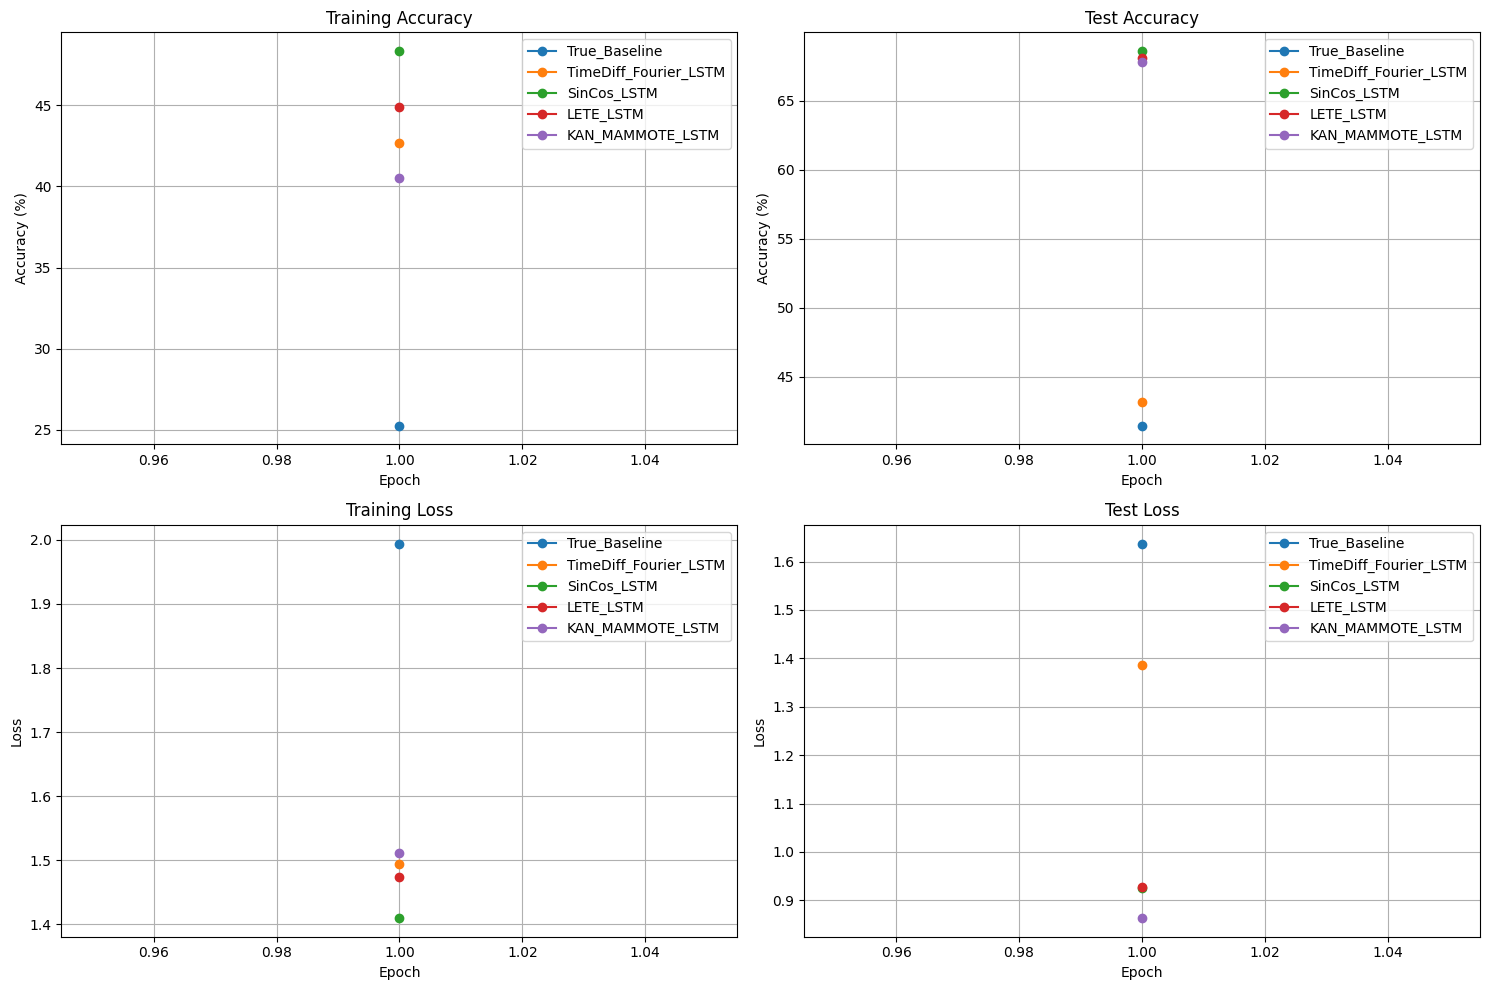

✅ Training curves saved to /home/peera/kan-mammote/results/training_curves.png

🎯 FINAL RESULTS SUMMARY:
True_Baseline       : 41.4500 acc | 200,458 params | 69.2s/epoch
TimeDiff_Fourier_LSTM: 43.1600 acc | 232,906 params | 83.3s/epoch
SinCos_LSTM         : 68.6200 acc | 232,842 params | 86.9s/epoch
LETE_LSTM           : 68.0900 acc | 252,650 params | 132.7s/epoch
KAN_MAMMOTE_LSTM    : 67.8600 acc | 309,918 params | 239.8s/epoch

🏆 Best Model: SinCos_LSTM (Accuracy: 68.6200)

💾 All results saved to: /home/peera/kan-mammote/results
🎉 Comparison complete!


In [5]:
def main():
    """Main execution function with improved error handling - STOP ON ERROR version."""
    print("🚀 Starting LSTM Time Embedding Comparison - FIXED VERSION (STOP ON ERROR)...")
    
    try:
        # Create datasets
        print("\n📁 Loading datasets...")
        train_dataset = EventBasedMNIST(root='./data', train=True, threshold=THRESHOLD, download=True)
        test_dataset = EventBasedMNIST(root='./data', train=False, threshold=THRESHOLD, download=True)
        
        # FIXED: Validate datasets
        if len(train_dataset) == 0 or len(test_dataset) == 0:
            raise ValueError("Empty dataset!")
        
        print(f"✅ Dataset loaded: {len(train_dataset)} train, {len(test_dataset)} test samples")
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
        
    except Exception as e:
        print(f"❌ ERROR LOADING DATASET - STOPPING: {e}")
        import traceback
        traceback.print_exc()
        return  # Stop execution
    
    # Define models to compare
    """
    'Learnable_Position': LearnablePositionLSTM(
        input_size=784,
        hidden_dim=LSTM_HIDDEN_DIM,
        num_classes=10,
        dropout=DROPOUT_RATE
    ),"""
        
    models = {

        'True_Baseline': TrueBaselineLSTM(
            input_size=784,
            hidden_dim=LSTM_HIDDEN_DIM,
            num_classes=10,
            dropout=DROPOUT_RATE
        ),
        'TimeDiff_Fourier_LSTM': TGATLSTM( # <--- ADD THIS LINE
            input_size=784,
            hidden_dim=LSTM_HIDDEN_DIM,
            num_classes=10,
            dropout=DROPOUT_RATE
        ),
        
        'SinCos_LSTM': SinCosLSTM(
            input_size=784,
            hidden_dim=LSTM_HIDDEN_DIM,
            num_classes=10,
            dropout=DROPOUT_RATE
        ),
        
        'LETE_LSTM': LETE_LSTM_Fixed(
            input_size=784,
            hidden_dim=LSTM_HIDDEN_DIM,
            num_classes=10,
            dropout=DROPOUT_RATE
        ),
        
        'KAN_MAMMOTE_LSTM': KAN_MAMMOTE_LSTM_Fixed(
            input_size=784,
            hidden_dim=LSTM_HIDDEN_DIM,
            num_classes=10,
            dropout=DROPOUT_RATE
        )
    }
    
    # Print model information
    print("\n📊 Model Information:")
    for name, model in models.items():
        try:
            param_count = count_parameters(model)
            print(f"   {name}: {param_count:,} parameters")
        except Exception as e:
            print(f"❌ ERROR COUNTING PARAMETERS FOR {name} - STOPPING: {e}")
            import traceback
            traceback.print_exc()
            return  # Stop execution if model parameter counting fails
    
    # Train all models
    results = {}
    best_accuracies = {}
    
    for model_name, model in models.items():
        print(f"\n" + "="*50)
        print(f"Starting training for {model_name}")
        print("="*50)
        
        # No try-except here - let errors propagate and stop execution
        history, best_acc = train_model(model, train_loader, test_loader, model_name)
        results[model_name] = history
        best_accuracies[model_name] = best_acc
        
        # Clean up memory after each model
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Save results
    print("\n💾 Saving results...")
    
    try:
        # Save training histories
        with open(f"{RESULTS_DIR}/training_histories.json", 'w') as f:
            json.dump(results, f, indent=2)
        
        # Save summary results
        summary = {
            'best_accuracies': best_accuracies,
            'model_parameters': {name: count_parameters(models[name]) if name in models else 0 for name in best_accuracies.keys()},
            'configuration': {
                'batch_size': BATCH_SIZE,
                'learning_rate': LEARNING_RATE,
                'num_epochs': NUM_EPOCHS,
                'lstm_hidden_dim': LSTM_HIDDEN_DIM,
                'time_embedding_dim': TIME_EMBEDDING_DIM,
                'dropout_rate': DROPOUT_RATE,
                'threshold': THRESHOLD
            }
        }
        
        with open(f"{RESULTS_DIR}/summary.json", 'w') as f:
            json.dump(summary, f, indent=2)
        
        # Create CSV summary
        with open(f"{RESULTS_DIR}/results_summary.csv", 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Model', 'Best_Accuracy', 'Parameters', 'Avg_Time_per_Epoch'])
            
            for model_name in best_accuracies.keys():
                if model_name in results and len(results[model_name]['training_time']) > 0:
                    avg_time = np.mean(results[model_name]['training_time'])
                    params = count_parameters(models[model_name])  # Fixed parameter name
                    writer.writerow([
                        model_name,
                        f"{best_accuracies[model_name]:.4f}",
                        params,
                        f"{avg_time:.2f}"
                    ])
        
        # Create visualizations
        if results:
            plot_training_curves(results)
        
    except Exception as e:
        print(f"❌ ERROR SAVING RESULTS - STOPPING: {e}")
        import traceback
        traceback.print_exc()
        return  # Stop execution
    
    # Print final summary
    print("\n🎯 FINAL RESULTS SUMMARY:")
    print("=" * 80)
    for model_name, acc in best_accuracies.items():
        params = count_parameters(models[model_name])
        if model_name in results and len(results[model_name]['training_time']) > 0:
            avg_time = np.mean(results[model_name]['training_time'])
            print(f"{model_name:20s}: {acc:.4f} acc | {params:7,} params | {avg_time:.1f}s/epoch")
    
    # Find best model
    if best_accuracies and any(acc > 0 for acc in best_accuracies.values()):
        best_model = max(best_accuracies, key=best_accuracies.get)
        print(f"\n🏆 Best Model: {best_model} (Accuracy: {best_accuracies[best_model]:.4f})")
    
    print(f"\n💾 All results saved to: {RESULTS_DIR}")
    print("🎉 Comparison complete!")

# Run the comparison
if __name__ == "__main__":
    main()

In [6]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("GPU device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


PyTorch version: 2.6.0+cu126
CUDA version: 12.6
CUDA available: True
GPU device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [7]:
import torch 
#check cuda
if torch.cuda.is_available():
    print("CUDA is available. Running on GPU.")
    

CUDA is available. Running on GPU.
